In [83]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [84]:
print("Hello")

Hello


# importing libraries

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision import models
import os
import time

# Building data loaders

In [86]:
dataset_dir = '/kaggle/input/img-dataset-q1/images'  

In [87]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

train_dir = os.path.join(dataset_dir, 'resized_train')
test_dir = os.path.join(dataset_dir, 'resized_test')

# Load the training and testing datasets using ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# Create DataLoader instances for training and testing
train_loader = DataLoader(train_data, batch_size=12, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# 1 block VGG

In [88]:
class SimpleVGGBlock(nn.Module):
    def __init__(self):
        super(SimpleVGGBlock, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 224 * 224, 2)  # Output layer with 2 units for binary classification

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc1(x)  # Output layer with 2 units
        return x

### Model definition

In [89]:
model = SimpleVGGBlock()
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification (binary classification with 2 classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
train_loss = []
train_acc = []

### Training and inference

In [90]:
start_time = time.time()
#Training 
writer = SummaryWriter('runs/experiment_2')

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass and loss computation
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Log training loss and accuracy
        writer.add_scalar('Loss/train', loss.item(), global_step=epoch * len(train_loader) + i)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0) * 100
        writer.add_scalar('Accuracy/train', accuracy, global_step=epoch * len(train_loader) + i)

    
end_time = time.time()

print(f'\nTime taken to train the model is {end_time - start_time}')

Epoch [1/10], Loss: 4.3827, Accuracy: 52.50%
Epoch [2/10], Loss: 1.5526, Accuracy: 75.00%
Epoch [3/10], Loss: 0.4025, Accuracy: 85.62%
Epoch [4/10], Loss: 0.1578, Accuracy: 95.62%
Epoch [5/10], Loss: 0.0525, Accuracy: 98.12%
Epoch [6/10], Loss: 0.0318, Accuracy: 98.75%
Epoch [7/10], Loss: 0.0105, Accuracy: 100.00%
Epoch [8/10], Loss: 0.0083, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0053, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0052, Accuracy: 100.00%

Time taken to train the model is 67.35146594047546


In [91]:
# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        # Log test accuracy for each iteration
        test_accuracy = 100 * correct / total
        writer.add_scalar('Accuracy/test', test_accuracy, global_step=epoch * len(test_loader) + i)
        # Log images and predictions
        img_grid = torchvision.utils.make_grid(inputs)
        writer.add_image('Test Images', img_grid, global_step=epoch * len(test_loader) + i)
        for j in range(len(inputs)):
            writer.add_text('Prediction', f'Predicted: {predicted[j]}, Ground truth: {labels[j]}', global_step=epoch * len(test_loader) + i)

# Close the writer at the end
writer.close()

# Number of model parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nNumber of model parameters: {total_params}")


Training loss history: [4.3826566849436075, 1.552585936018399, 0.40253537081714186, 0.1578005095548828, 0.0524515777617905, 0.03182745573160771, 0.010477948592909212, 0.008256999917128789, 0.005282958129620445, 0.005150067919333067]

Training accuracy history: [52.5, 75.0, 85.625, 95.625, 98.125, 98.75, 100.0, 100.0, 100.0, 100.0]

Test Accuracy: 57.50%

Number of model parameters: 3216354


# 3 block VGG 

In [92]:
class VGG3Block(nn.Module):
    def __init__(self):
        super(VGG3Block, self).__init__()
        
        # 3 convolutional blocks with Conv2d and MaxPool2d
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool
        )
        
        self.fc1 = nn.Linear(256 * 28 * 28, 512)  
        self.fc2 = nn.Linear(512, 2)  # Output layer with 2 units (binary classification)

    def forward(self, x):
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        x = x.view(x.size(0), -1)
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  
        
        return x

In [93]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [94]:
model_two_3blocks = VGG3Block().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model_two_3blocks.parameters(), lr=0.0001)
train_loss = []
train_acc = []

In [95]:
start_time = time.time()

num_epochs = 10
for epoch in range(num_epochs):
    model_two_3blocks.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  
        outputs = model_two_3blocks(inputs)  
        loss = criterion(outputs, labels)  
        loss.backward()  
        optimizer.step()  
        
        running_loss += loss.item() 
        
        _, predicted = torch.max(outputs, 1)  
        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  
    
    accuracy = 100 * correct / total
    train_loss.append(running_loss/len(train_loader))
    train_acc.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

end_time = time.time()
print(f'\nTime taken to train the model_two_3blocks is {end_time - start_time:.2f} seconds')

Epoch [1/10], Loss: 0.7069, Accuracy: 47.50%
Epoch [2/10], Loss: 0.6920, Accuracy: 50.00%
Epoch [3/10], Loss: 0.6521, Accuracy: 70.62%
Epoch [4/10], Loss: 0.5666, Accuracy: 72.50%
Epoch [5/10], Loss: 0.4931, Accuracy: 76.25%
Epoch [6/10], Loss: 0.4394, Accuracy: 81.88%
Epoch [7/10], Loss: 0.3043, Accuracy: 88.75%
Epoch [8/10], Loss: 0.2413, Accuracy: 91.25%
Epoch [9/10], Loss: 0.3311, Accuracy: 85.62%
Epoch [10/10], Loss: 0.1915, Accuracy: 91.88%

Time taken to train the model_two_3blocks is 13.76 seconds


In [96]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        test_accuracy = 100 * correct / total
        writer.add_scalar('Accuracy/test', test_accuracy, global_step=epoch * len(test_loader) + i)
        img_grid = torchvision.utils.make_grid(inputs)
        writer.add_image('Test Images', img_grid, global_step=epoch * len(test_loader) + i)
        for j in range(len(inputs)):
                writer.add_text('Prediction', f'Predicted: {predicted[j]}, Ground truth: {labels[j]}', global_step=epoch * len(test_loader) + i)

writer.close()

print(f"\nTraining loss history: \n{train_loss}")
print(f"\nTraining accuracy history:\n {train_acc}")
print(f"\nTest Accuracy: {test_accuracy:.2f}%")
print(f"\nNumber of model_two_3blocks parameters: {total_params}")


Training loss history: 
[0.7068865426949092, 0.6920378335884639, 0.6521020701953343, 0.5665593317576817, 0.4931241933788572, 0.439425385424069, 0.3043070925133569, 0.24131992938263075, 0.3311056944408587, 0.19148210462714946]

Training accuracy history:
 [47.5, 50.0, 70.625, 72.5, 76.25, 81.875, 88.75, 91.25, 85.625, 91.875]

Test Accuracy: 67.50%

Number of model_two_3blocks parameters: 103907394


# 3 block with image augmentation 

In [97]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(20), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG normalization
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG normalization
])


train_dir = os.path.join(dataset_dir, 'resized_train')
test_dir = os.path.join(dataset_dir, 'resized_test')

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

class VGGBlock(nn.Module):
    def __init__(self):
        super(VGGBlock, self).__init__()
        
        # 3 convolutional blocks with Conv2d and MaxPool2d
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Conv1
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPool
        )
        
        # Fully connected layer for binary classification
        self.fc1 = nn.Linear(256 * 28 * 28, 512)  # Linear layer after flattening the output of the conv layers
        self.fc2 = nn.Linear(512, 2)  # Output layer with 2 units (binary classification)

    def forward(self, x):
        # Pass the input through each block
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        
        return x

In [98]:
model_data_aug = VGGBlock().to(device) 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model_data_aug.parameters(), lr=0.0001)

train_loss = []
train_acc = []

start_time = time.time()

num_epochs = 10
for epoch in range(num_epochs):
    model_data_aug.train()  
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() 
        
        outputs = model_data_aug(inputs)  
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step() 
        
        running_loss += loss.item()  
        
        _, predicted = torch.max(outputs, 1) 
        
        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  
        
        if (i + 1) % 10 == 0:
            batch_accuracy = 100 * correct / total
            print(f"Batch [{i+1}/{len(train_loader)}] Loss: {running_loss / (i+1):.4f}, Accuracy: {batch_accuracy:.2f}%")
    
    accuracy = 100 * correct / total
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

end_time = time.time()
print(f'\nTime taken to train the model_data_aug: {end_time - start_time} seconds')


Batch [10/20] Loss: 0.7207, Accuracy: 50.00%
Batch [20/20] Loss: 0.7107, Accuracy: 46.25%
Epoch [1/10], Loss: 0.7107, Accuracy: 46.25%
Batch [10/20] Loss: 0.6942, Accuracy: 48.75%
Batch [20/20] Loss: 0.6934, Accuracy: 50.00%
Epoch [2/10], Loss: 0.6934, Accuracy: 50.00%
Batch [10/20] Loss: 0.6881, Accuracy: 57.50%
Batch [20/20] Loss: 0.6916, Accuracy: 51.25%
Epoch [3/10], Loss: 0.6916, Accuracy: 51.25%
Batch [10/20] Loss: 0.6832, Accuracy: 63.75%
Batch [20/20] Loss: 0.6926, Accuracy: 56.88%
Epoch [4/10], Loss: 0.6926, Accuracy: 56.88%
Batch [10/20] Loss: 0.6757, Accuracy: 52.50%
Batch [20/20] Loss: 0.6659, Accuracy: 56.88%
Epoch [5/10], Loss: 0.6659, Accuracy: 56.88%
Batch [10/20] Loss: 0.6351, Accuracy: 70.00%
Batch [20/20] Loss: 0.5896, Accuracy: 73.12%
Epoch [6/10], Loss: 0.5896, Accuracy: 73.12%
Batch [10/20] Loss: 0.5438, Accuracy: 72.50%
Batch [20/20] Loss: 0.5336, Accuracy: 71.25%
Epoch [7/10], Loss: 0.5336, Accuracy: 71.25%
Batch [10/20] Loss: 0.5341, Accuracy: 75.00%
Batch [20/

In [99]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        test_accuracy = 100 * correct / total
        writer.add_scalar('Accuracy/test', test_accuracy, global_step=epoch * len(test_loader) + i)
        img_grid = torchvision.utils.make_grid(inputs)
        writer.add_image('Test Images', img_grid, global_step=epoch * len(test_loader) + i)
        for j in range(len(inputs)):
            writer.add_text('Prediction', f'Predicted: {predicted[j]}, Ground truth: {labels[j]}', global_step=epoch * len(test_loader) + i)

writer.close()

total_params = sum(p.numel() for p in model_data_aug.parameters() if p.requires_grad)
print(f"\nNumber of model_data_aug parameters: {total_params}")


Test Accuracy: 75.00%

Number of model_data_aug parameters: 103907394


# testing ai images 

In [100]:
from PIL import Image
import numpy as np

File name: easy_rabbit.jpg


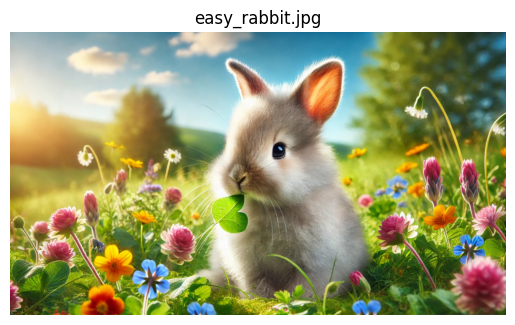

File name: easy_antelope.jpg


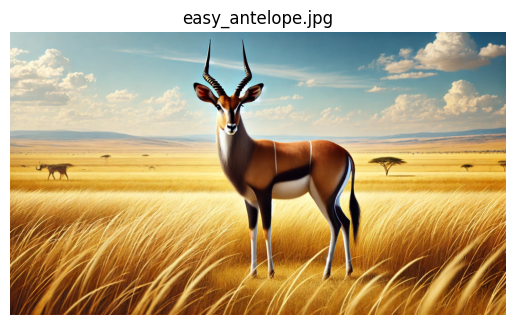

File name: hard_rabbit.jpg


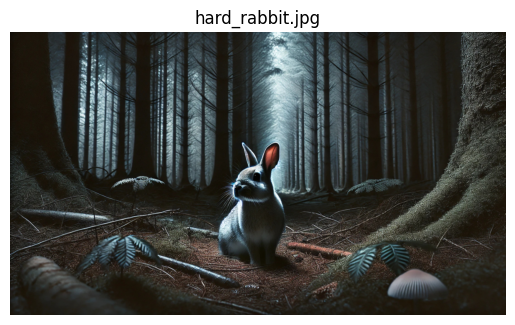

File name: hard_antelope.jpg


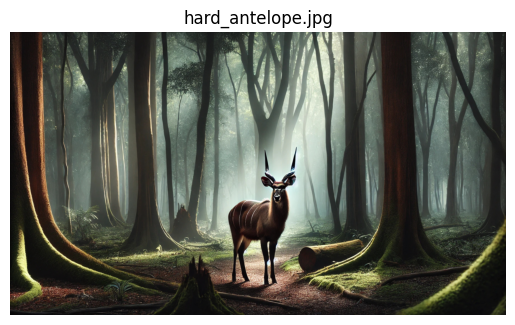

In [118]:
import os
from PIL import Image as PILImage
import matplotlib.pyplot as plt

folder_path = "/kaggle/input/img-generated-ai"

# List all files in the folder
if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
    image_files = [f for f in files if f.lower().endswith(image_extensions)]
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        print(f"File name: {image_file}")
        img = PILImage.open(image_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(image_file)
        plt.show()
else:
    print(f"The folder path '{folder_path}' does not exist.")

In [101]:
folder_path = '/kaggle/input/img-generated-ai'
label_mapping = {
    "antelope": 0,
    "rabbit": 1
}

test_images = []
test_labels = []
file_names = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(('.png', '.jpg', '.jpeg')):  
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path).convert("RGB")  
        
        image = image.resize((224, 224))
        
        image_array = np.array(image)
        test_images.append(image_array)
        
        file_names.append(file_name)
        
        if "antelope" in file_name.lower():
            test_labels.append(label_mapping["antelope"])
        elif "rabbit" in file_name.lower():
            test_labels.append(label_mapping["rabbit"])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")
print(f"File Names: {file_names}")
print(f"Labels: {test_labels}")

Test Images Shape: (4, 224, 224, 3)
Test Labels Shape: (4,)
File Names: ['easy_rabbit.jpg', 'easy_antelope.jpg', 'hard_rabbit.jpg', 'hard_antelope.jpg']
Labels: [1 0 1 0]


In [102]:
from torch.utils.data import DataLoader, Dataset

In [103]:
class CustomTestDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [104]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

test_dataset_gen = CustomTestDataset(test_images, test_labels, transform=transform)
test_loader_gen = DataLoader(test_dataset_gen, batch_size=1, shuffle=False)

In [105]:
def test_fnai(model_gen):    
    model_gen.eval()  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_gen = model_gen.to(device)  
    
    # Inference loop
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():  
        for images, labels in test_loader_gen:
            images = images.to(device)  
            labels = labels.to(device)  
    
            outputs = model_gen(images)  
            
            probabilities = torch.softmax(outputs, dim=1) 
            predictions = torch.argmax(probabilities, dim=1) 

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print(all_predictions)
    print(all_labels)

## 1 block vgg
able to detect only rabits

In [106]:
test_fnai(model)

[1, 1, 1, 1]
[1, 0, 1, 0]


## 3 block vgg
able to catch both rabbits and easy antelope

In [107]:
test_fnai(model_two_3blocks)

[1, 1, 1, 1]
[1, 0, 1, 0]


## 3 block and img augmentation
able to catch both rabbits

In [108]:
test_fnai(model_data_aug)

[1, 1, 1, 1]
[1, 0, 1, 0]


# Fine tuning

In [109]:
weight_path = "/kaggle/input/vgg16_image_net_model_check/pytorch/default/1/vgg16-397923af.pth"

In [110]:
vgg16 = models.vgg16(pretrained=False)  # Set pretrained=False, we will load weights manually

weights = torch.load(weight_path)

vgg16.load_state_dict(weights)

vgg16.classifier[6] = nn.Linear(4096, 1)  

for param in vgg16.parameters():
    param.requires_grad = True

# print(vgg16)

/tmp/ipykernel_31/515960549.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weight_path)


In [111]:
device = 'cuda'
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [112]:
loss_fn = nn.BCEWithLogitsLoss()  # This takes logits as input and applies sigmoid internally
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

train_loss = []
train_acc = []

start_time = time.time()

num_epochs = 20
for epoch in range(num_epochs):
    vgg16.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  
        
        outputs = vgg16(inputs)  
        
        loss = loss_fn(outputs.squeeze(), labels.float())  
        loss.backward()  
        optimizer.step() 
        
        running_loss += loss.item()  
        
        predicted = torch.sigmoid(outputs).squeeze()  
        predicted = (predicted >= 0.5).float()  
        
        correct += (predicted == labels).sum().item() 
        total += labels.size(0) 
        # print(correct, total)
        
        if (i + 1) % 10 == 0:
            batch_accuracy = 100 * correct / total
            print(f"Batch [{i+1}/{len(train_loader)}] Loss: {running_loss / (i+1):.4f}, Accuracy: {batch_accuracy:.2f}%")
    
    accuracy = 100 * correct / total
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

end_time = time.time()
print(f'\nTime taken to train the model: {end_time - start_time} seconds')

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = vgg16(inputs) 
        
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (0 or 1)
        
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct / total
        writer.add_scalar('Accuracy/test', test_accuracy, global_step=epoch * len(test_loader) + i)

        mg_grid = torchvision.utils.make_grid(inputs)
        writer.add_image('Test Images', img_grid, global_step=epoch * len(test_loader) + i)
        for j in range(len(inputs)):
            writer.add_text('Prediction', f'Predicted: {predicted[j]}, Ground truth: {labels[j]}', global_step=epoch * len(test_loader) + i)


test_accuracy = 100 * correct / total
writer.close()
print(f"\nTest Accuracy: {test_accuracy:.2f}%")


# torch.save(vgg16.state_dict(), 'vgg16.pt')


Batch [10/20] Loss: 2.4625, Accuracy: 53.75%
Batch [20/20] Loss: 1.6073, Accuracy: 51.25%
Epoch [1/20], Loss: 1.6073, Accuracy: 51.25%
Batch [10/20] Loss: 0.7468, Accuracy: 48.75%
Batch [20/20] Loss: 0.7431, Accuracy: 45.62%
Epoch [2/20], Loss: 0.7431, Accuracy: 45.62%
Batch [10/20] Loss: 0.7329, Accuracy: 50.00%
Batch [20/20] Loss: 0.7194, Accuracy: 53.12%
Epoch [3/20], Loss: 0.7194, Accuracy: 53.12%
Batch [10/20] Loss: 0.7195, Accuracy: 53.75%
Batch [20/20] Loss: 0.7099, Accuracy: 51.25%
Epoch [4/20], Loss: 0.7099, Accuracy: 51.25%
Batch [10/20] Loss: 0.7021, Accuracy: 50.00%
Batch [20/20] Loss: 0.7130, Accuracy: 49.38%
Epoch [5/20], Loss: 0.7130, Accuracy: 49.38%
Batch [10/20] Loss: 0.7000, Accuracy: 50.00%
Batch [20/20] Loss: 0.7031, Accuracy: 50.00%
Epoch [6/20], Loss: 0.7031, Accuracy: 50.00%
Batch [10/20] Loss: 0.7063, Accuracy: 42.50%
Batch [20/20] Loss: 0.7122, Accuracy: 47.50%
Epoch [7/20], Loss: 0.7122, Accuracy: 47.50%
Batch [10/20] Loss: 0.7151, Accuracy: 48.75%
Batch [20/

In [119]:
total_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
print(f"\nNumber of model parameters: {total_params}")


Number of model parameters: 134264641


In [113]:
test_fnai(vgg16)

[0, 0, 0, 0]
[1, 0, 1, 0]


Only able to guess antelopes

# fine tuning last layer

In [114]:
vgg16_last = models.vgg16(pretrained=False)
# weight_path = "/kaggle/input/vgg16_image_net_/pytorch/default/1/vgg16-397923af.pth"
weights = torch.load(weight_path)

vgg16_last.load_state_dict(weights)

/tmp/ipykernel_31/1241618478.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(weight_path)


<All keys matched successfully>

In [115]:
device = 'cpu'
vgg16_last.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [116]:
vgg16_last.classifier[6] = nn.Linear(4096, 2)

for param in vgg16_last.parameters():
    param.requires_grad = False

for param in vgg16_last.classifier[6].parameters():
    param.requires_grad = True

vgg16_last.to(device)

loss_fn_ = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_last.classifier[6].parameters(), lr=0.001)  

def train_epoch(model, train_loader, optimizer, loss_fn, device):
    
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  
        
        # Forward pass
        outputs = model(inputs)
        loss = loss_fn_(outputs, labels)
        loss.backward()  
        optimizer.step()  
        
        running_loss += loss.item()
        writer.add_scalar('Loss/train', loss.item(), global_step=epoch * len(train_loader) + i)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        global_step=epoch * len(train_loader) + i)
        _, predicted = torch.max(outputs, 1)

    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    writer.add_scalar('Accuracy/test', test_accuracy, global_step=epoch * len(test_loader) + i)
    img_grid = torchvision.utils.make_grid(inputs)
    writer.add_image('Test Images', img_grid, global_step=epoch * len(test_loader) + i)
    for j in range(len(inputs)):
        writer.add_text('Prediction', f'Predicted: {predicted[j]}, Ground truth: {labels[j]}', global_step=epoch * len(test_loader) + i)

    return accuracy

num_epochs = 10
train_loss, train_acc = [], []
start_time = time.time()
writer = SummaryWriter('runs/experiment_2')
for epoch in range(num_epochs):
    avg_loss, accuracy = train_epoch(vgg16_last, train_loader, optimizer, loss_fn, device)
    train_loss.append(avg_loss)
    train_acc.append(accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

end_time = time.time()
print(f'\nTime taken to train the model: {end_time - start_time:.2f} seconds')

test_accuracy = evaluate(vgg16_last, test_loader, device)
print(f"\nTest Accuracy: {test_accuracy:.2f}%")
writer.close()

total_params = sum(p.numel() for p in vgg16_last.parameters() if p.requires_grad)
print(f"\nNumber of model parameters: {total_params}")

torch.save(vgg16_last.state_dict(), 'vgg16_finetunelast.pt')

Epoch [1/10], Loss: 0.3710, Accuracy: 81.88%
Epoch [2/10], Loss: 0.1635, Accuracy: 93.75%
Epoch [3/10], Loss: 0.1600, Accuracy: 95.00%
Epoch [4/10], Loss: 0.1039, Accuracy: 95.62%
Epoch [5/10], Loss: 0.1296, Accuracy: 95.00%
Epoch [6/10], Loss: 0.0645, Accuracy: 98.12%
Epoch [7/10], Loss: 0.0648, Accuracy: 97.50%
Epoch [8/10], Loss: 0.0695, Accuracy: 96.88%
Epoch [9/10], Loss: 0.0585, Accuracy: 98.12%
Epoch [10/10], Loss: 0.0987, Accuracy: 95.00%

Time taken to train the model: 338.29 seconds

Test Accuracy: 92.50%

Number of model parameters: 8194


In [117]:
test_fnai(vgg16_last)

[1, 0, 0, 0]
[1, 0, 1, 0]


unable to detected hard rabbit

# Summary Table

In [123]:
import pandas as pd
df = pd.read_csv('/kaggle/input/model-summary-csv/final_summary_models.csv')

new_row_names = ['1Block', '3Block', '3Block+Augmentation', 'VGG-16-All Layers', 'VGG16-Final Layer']  # Ensure the length matches the number of rows
df.index = new_row_names
df

,Train_Time,Train_Accuracy,Test_Accuracy,Final_Loss,Parameters
1Block,5.30,1.00,0.570,0.005,3.21 MILLION
3Block,13.76,0.92,0.675,0.190,109 MILLION
3Block+Augmentation,23.50,0.73,0.750,0.480,109 MILLION
VGG-16-All Layers,30.00,0.46,0.500,0.700,134264641
VGG16-Final Layer,3.00,0.95,0.925,0.090,8194
